# U-net을 활용하여 segmentation

## 데이터셋 준비


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import xml.etree.ElementTree as et
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!tar -xf /content/gdrive/My\ Drive/Colab\ Notebooks/Oxford-IIIT/images.tar.gz

In [4]:
!tar -xf /content/gdrive/My\ Drive/Colab\ Notebooks/Oxford-IIIT/annotations.tar.gz

In [5]:
cur_dir = os.getcwd()
image_dir = os.path.join(cur_dir,'images')
bbox_dir = os.path.join(cur_dir,'annotations','xmls')

seg_dir = os.path.join(cur_dir,'annotations','trimaps')
#경로는 content 바로 아래 풀려있다

In [6]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']#확장자가 jpg인거만
print(len(image_files))#7390개

7390


In [7]:
seg_files = [fname for fname in os.listdir(seg_dir) if os.path.splitext(fname)[-1] == '.png' and os.path.splitext(fname)[0][0] != '.']#확장자가 png인거만, os.listdir에서 에러가 계속나서 임시방편
print(len(seg_files))#7390개

7390


In [8]:
#image file중 channel이 3이 아니면 삭제
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    seg_file = os.path.splitext(image_file)[0]+'.png'
    seg_path = os.path.join(seg_dir,seg_file)
    image = Image.open(image_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        print(image_file, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(image_path)
        os.remove(seg_path)
#channel 4개 혹은 흑백이미지 삭제

Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_167.jpg P
(275, 183)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_145.jpg P
(188, 216)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Egyptian_Mau_139.jpg P
(250, 350)


In [9]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']#확장자가 jpg인거만
print(len(image_files))#7378개

7378


In [10]:
seg_files = [fname for fname in os.listdir(seg_dir) if os.path.splitext(fname)[-1] == '.png' and os.path.splitext(fname)[0][0] != '.']#확장자가 png인거만, os.listdir에서 에러가 계속나서 임시방편
print(len(seg_files))#7378개

7378


In [11]:
#집합으로 이름을 정리
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+','',file_name)#뒤에 숫자 pug_111같은거에서 삭제
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [12]:
#정렬
class_list.sort()
class2idx = {cls:idx for idx,cls in enumerate(class_list)}#딕셔너리로 만들어서 one-hot encoding쉽게하자

In [13]:
#train,validation 나누기
train_dir = os.path.join(cur_dir, 'train')
val_dir = os.path.join(cur_dir, 'validation')
os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)

In [14]:
image_files.sort()

In [15]:
cnt = 0
previous_class = ""
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+','',file_name)
    if class_name == previous_class:
        cnt+=1
    else:
        cnt = 1
    if cnt<=160:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir, image_file)
    shutil.copy(image_path, cpath)
    previous_class = class_name        

In [16]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)
print(len(train_images),len(val_images))

5920 1458


### seg 이미지 확인

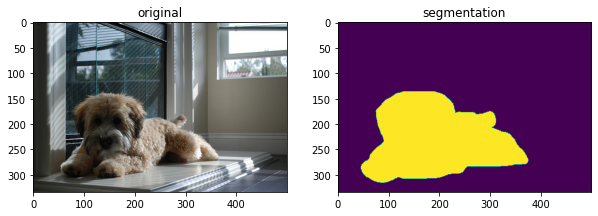

In [19]:
rnd_idx = random.randint(0,len(val_images)-1)
fname = val_images[rnd_idx]

fpath = os.path.join(val_dir, fname)
image = Image.open(fpath)
image = np.array(image)

# label 1 : foreground, label 2: background, label 3: not classified
# 에서 0부터 시작하게 바꿔준다. 문제를 단순하게 하기위해 3을 없애고
# 0 : background 1: foreground& & not classified

sname = os.path.splitext(fname)[0] +'.png'
spath = os.path.join(seg_dir,sname)
seg = Image.open(spath)
seg = np.array(seg)
seg[seg>2] = 1
seg[seg == 2] =0

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('original')
plt.imshow(image)
plt.subplot(1,2,2)
plt.title('segmentation')
plt.imshow(seg)
plt.show()
# 너무귀엽다 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ

## TFrecord

In [20]:
IMG_SIZE = 224
N_TRAIN = len(train_images)
N_VAL = len(val_images)

In [22]:
#tfreord저장할곳
#tfrecord file이란 tf를 위한 바이너리 파일 파이프라인 자동 구성됨.
tfr_dir = os.path.join(cur_dir,'tfrecord')
os.makedirs(tfr_dir,exist_ok=True)

tfr_train_dir=os.path.join(tfr_dir,'cls_train.tfr')
tfr_val_dir=os.path.join(tfr_dir,'cls_val.tfr')

In [23]:
#tfrecord writer생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [24]:
#tensorflow 듀토리얼에서 긁어옴.
# https://www.tensorflow.org/tutorials/load_data/tfrecord
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [27]:
#training -> tfrecord
n_train = 0#개수확인용

train_files = os.listdir(train_dir)
for train_file in train_files:
    train_path = os.path.join(train_dir, train_file)
    image = Image.open(train_path)
    image = image.resize((IMG_SIZE,IMG_SIZE))
    bimage = image.tobytes()

    file_name = os.path.splitext(train_file)[0]
    class_name = re.sub('_\d+','',file_name)
    class_num = class2idx[class_name]

    if file_name[0].islower():
        bi_cls_num = 0
    else :
        bi_cls_num = 1
    
    seg_name = file_name + '.png'
    seg_path = os.path.join(seg_dir,seg_name)
    seg = Image.open(seg_path)
    seg = seg.resize((IMG_SIZE,IMG_SIZE))
    seg = np.array(seg)
    seg[seg>2] = 1
    seg[seg==2] = 0
    bseg = seg.tobytes()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image':_bytes_feature(bimage),
        'cls_num':_int64_feature(class_num),
        'bi_cls_num':_int64_feature(bi_cls_num),
        'seg' : _bytes_feature(bseg)
    }))
    writer_train.write(example.SerializeToString())
    n_train += 1

writer_train.close()
print(n_train)

5920


In [28]:
#validation -> tfrecord
n_val = 0#개수확인용

val_files = os.listdir(val_dir)
for val_file in val_files:
    val_path = os.path.join(val_dir, val_file)
    image = Image.open(val_path)
    image = image.resize((IMG_SIZE,IMG_SIZE))
    bimage = image.tobytes()

    file_name = os.path.splitext(val_file)[0]
    class_name = re.sub('_\d+','',file_name)
    class_num = class2idx[class_name]

    if file_name[0].islower():
        bi_cls_num = 0
    else :
        bi_cls_num = 1

    seg_name = file_name + '.png'
    seg_path = os.path.join(seg_dir,seg_name)
    seg = Image.open(seg_path)
    seg = seg.resize((IMG_SIZE,IMG_SIZE))
    seg = np.array(seg)
    seg[seg>2] = 1
    seg[seg==2] = 0
    bseg = seg.tobytes()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image':_bytes_feature(bimage),
        'cls_num':_int64_feature(class_num),
        'bi_cls_num':_int64_feature(bi_cls_num),
        'seg' : _bytes_feature(bseg)
    }))
    writer_val.write(example.SerializeToString())
    n_val += 1

writer_val.close()
print(n_val)

1458


In [29]:
!ls -l $tfr_dir

total 1446836
-rw-r--r-- 1 root root 1188777440 Aug 19 14:36 cls_train.tfr
-rw-r--r-- 1 root root  292776606 Aug 19 14:37 cls_val.tfr


In [30]:
#하이퍼 파라미터
N_CLASS = len(class_list)
N_EPOCHS = 20
N_BATCH = 40
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN/N_BATCH#1480
validation_steps = int(np.ceil(N_VAL/N_BATCH))#37

In [34]:
#tfrecord를 data로 parsing
def _parse_function(tfrecord_serialized):
    features={'image':tf.io.FixedLenFeature([],tf.string),
              'cls_num':tf.io.FixedLenFeature([],tf.int64),
              'bi_cls_num':tf.io.FixedLenFeature([],tf.int64),
              'seg':tf.io.FixedLenFeature([],tf.string)
              }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)#요래 생겼어!! 알려줌

    image = tf.io.decode_raw(parsed_features['image'],tf.uint8)
    image = tf.reshape(image, [IMG_SIZE,IMG_SIZE, 3])
    image = tf.cast(image,tf.float32)/255.0

    cls_label = tf.cast(parsed_features['cls_num'],tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'],tf.int64)

    seg = tf.io.decode_raw(parsed_features['seg'],tf.uint8)
    seg = tf.reshape(seg, [IMG_SIZE,IMG_SIZE, -1])
    seg = tf.cast(seg,tf.float32)

    return image,seg

In [35]:
#train_dataset
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [36]:
#val_dataset
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

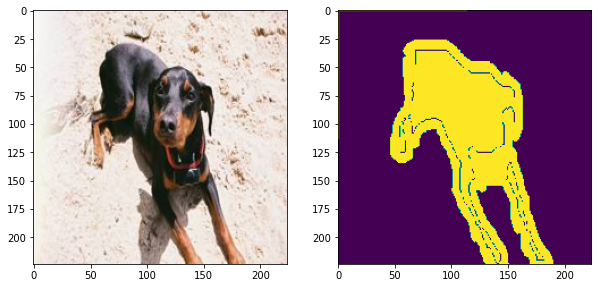

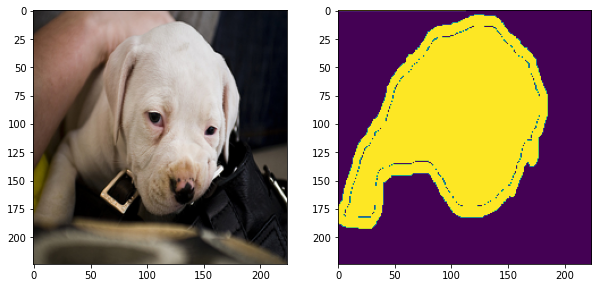

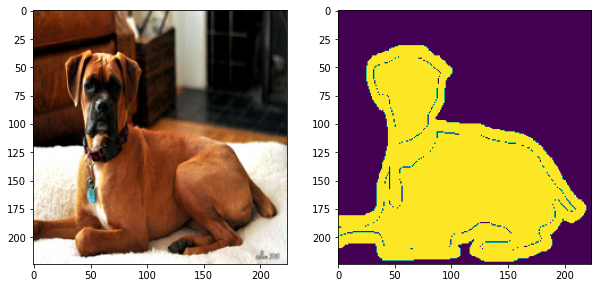

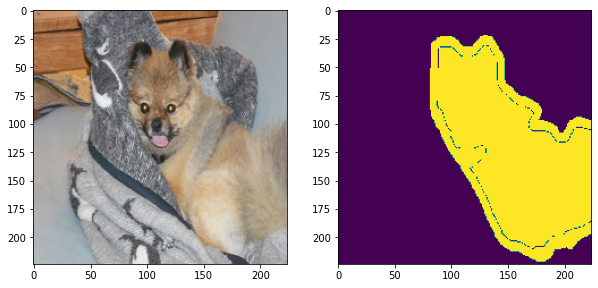

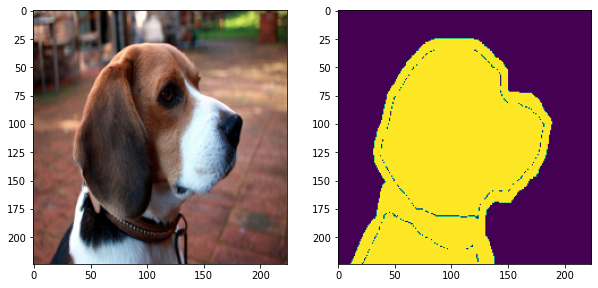

In [40]:
#잘 되었니..?
for image, seg in train_dataset.take(5):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image[0])
    plt.subplot(1,2,2)
    plt.imshow(seg[0,:,:,0])
    plt.show()
# 선은 reshape때문이다!!!

# U-Net like model을 random initialization으로 학습하기

In [42]:
from tensorflow.keras.layers import Conv2D,ReLU,MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Input,Conv2DTranspose

In [ ]:
#이거도 functional api쓰자.
def MyModel():
    inputs = Input(shape=(IMG_SIZE,IMG_SIZE,3))

    conv1_1 = Conv2D(64,3,1,'same',activation='relu')(inputs)
    conv1_2 = Conv2D(64,3,1,'same',activation='relu')(conv1_1)
    pool1_3 = MaxPooling2D()(conv1_2)

    conv2_1 = Conv2D(128,3,1,'same',activation='relu')(pool1_3)
    conv2_2 = Conv2D(128,3,1,'same',activation='relu')(conv2_1)
    pool2_3 = MaxPooling2D()(conv2_2)

    conv3_1 = Conv2D(256,3,1,'same',activation='relu')(pool2_3)
    conv3_2 = Conv2D(256,3,1,'same',activation='relu')(conv3_1)
    conv3_3 = Conv2D(256,3,1,'same',activation='relu')(conv3_2)
    pool3_4 = MaxPooling2D()(conv3_3)

    conv4_1 = Conv2D(256,3,1,'same',activation='relu')(pool3_3)
    conv4_2 = Conv2D(256,3,1,'same',activation='relu')(conv4_1)
    conv4_3 = Conv2D(256,3,1,'same',activation='relu')(conv4_2)
    pool4_4 = MaxPooling2D()(conv4_3)

    conv5_1 = Conv2D(256,3,1,'same',activation='relu')(pool3_3)
    conv5_2 = Conv2D(256,3,1,'same',activation='relu')(conv4_1)
    conv5_3 = Conv2D(256,3,1,'same',activation='relu')(conv4_2)
    pool5_4 = MaxPooling2D()(conv4_3)

    #u에서 왼쪽 처럼 쭈우ㅜ우우욱 내려왔다.